In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch
import random


In [2]:
orase = {
    'București': (44.4, 26.1),
    'Cluj-Napoca': (46.8, 23.6),
    'Timișoara': (45.7, 21.2),
    'Iași': (47.2, 27.6),
    'Constanța': (44.2, 28.6),
    'Craiova': (44.3, 23.8),
    'Brașov': (45.6, 25.6),
    'Ploiești': (44.9, 26.0)
}

lista_orase = list(orase.keys())
numar_orase = len(lista_orase)

print(f"Avem {numar_orase} orașe: {lista_orase}")

Avem 8 orașe: ['București', 'Cluj-Napoca', 'Timișoara', 'Iași', 'Constanța', 'Craiova', 'Brașov', 'Ploiești']


In [11]:
def calculeaza_distante(orase, lista_orase):
    """
    Calculează distanțele euclidiene între toate perechile de orașe
    
    Parametri:
    - orase: dicționar cu coordonatele orașelor
    - lista_orase: lista cu numele orașelor
    
    Returnează: matricea distanțelor
    """
    numar_orase = len(lista_orase)
    distante = np.zeros((numar_orase, numar_orase))
    
    for i in range(numar_orase):
        for j in range(numar_orase):
            if i != j:
                # Coordonatele celor două orașe
                oras1 = orase[lista_orase[i]]
                oras2 = orase[lista_orase[j]]
                
                # Distanța euclidiana (teorema lui Pitagora în 2D)
                distanta = np.sqrt((oras1[0] - oras2[0])**2 + (oras1[1] - oras2[1])**2)
                distante[i][j] = distanta
    
    return distante

# Calculez matricea distanțelor
matricea_distante = calculeaza_distante(orase, lista_orase)

# Afișez câteva exemple
print("Exemple de distanțe:")
print(f"București → Cluj-Napoca: {matricea_distante[0][1]:.2f}")
print(f"Cluj-Napoca → Timișoara: {matricea_distante[1][2]:.2f}")

Exemple de distanțe:
București → Cluj-Napoca: 3.47
Cluj-Napoca → Timișoara: 2.64


In [12]:
def creaza_conexiuni(matricea_distante, distanta_maxima=2.5):
    """
    Creează conexiunile între orașe bazate pe distanța maximă permisă
    
    Parametri:
    - matricea_distante: matricea cu distanțele între orașe
    - distanta_maxima: distanța maximă pentru o conexiune directă
    
    Returnează: dicționar cu conexiunile fiecărui oraș
    """
    numar_orase = len(matricea_distante)
    conexiuni = {}
    
    for i in range(numar_orase):
        conexiuni[i] = []
        # Găsesc toate orașele conectate la orașul i
        for j in range(numar_orase):
            if i != j and matricea_distante[i][j] <= distanta_maxima:
                conexiuni[i].append(j)
        
        # Dacă un oraș nu are conexiuni, îl conectez la cel mai apropiat
        if not conexiuni[i]:
            cel_mai_apropiat = 0
            distanta_minima = float('inf')
            
            # Caut cel mai apropiat oraș
            for j in range(numar_orase):
                if i != j and matricea_distante[i][j] < distanta_minima:
                    distanta_minima = matricea_distante[i][j]
                    cel_mai_apropiat = j
            
            conexiuni[i].append(cel_mai_apropiat)
    return conexiuni

# Creez conexiunile
conexiuni_orase = creaza_conexiuni(matricea_distante)

# Afișez conexiunile pentru fiecare oraș
print("Conexiunile orașelor:")
for i, conexiuni_oras in conexiuni_orase.items():
    nume_oras = lista_orase[i]
    conexiuni_nume = [lista_orase[j] for j in conexiuni_oras]
    print(f"{nume_oras}: {conexiuni_nume}")

Conexiunile orașelor:
București: ['Craiova', 'Brașov', 'Ploiești']
Cluj-Napoca: ['Brașov']
Timișoara: ['Cluj-Napoca']
Iași: ['Brașov']
Constanța: ['București']
Craiova: ['București', 'Brașov', 'Ploiești']
Brașov: ['București', 'Cluj-Napoca', 'Craiova', 'Ploiești']
Ploiești: ['București', 'Craiova', 'Brașov']


In [13]:
# Parametrii algoritmului Q-Learning
RATA_INVATARE = 0.1    # Cât de repede învață agentul (0.0 - 1.0)
DISCOUNT = 0.9         # Cât de mult valorează recompensele viitoare (0.0 - 1.0)  
EXPLORARE = 0.2        # Cât de mult explorează vs. folosește cunoștințele (0.0 - 1.0)

# Tabelul Q - "creierul" agentului
# Fiecare celulă [i][j] spune cât de bună e decizia de a merge din orașul i în orașul j
tabel_q = np.zeros((numar_orase, numar_orase))

print("Parametrii Q-Learning:")
print(f"- Rata de învățare: {RATA_INVATARE} (cât de repede își schimbă părerile)")
print(f"- Discount factor: {DISCOUNT} (cât de mult se gândește la viitor)")
print(f"- Rata de explorare: {EXPLORARE} (cât de mult încearcă lucruri noi)")
print(f"\nTabelul Q inițial are forma: {tabel_q.shape}")
print("Toate valorile sunt 0 - agentul nu știe nimic încă!")

Parametrii Q-Learning:
- Rata de învățare: 0.1 (cât de repede își schimbă părerile)
- Discount factor: 0.9 (cât de mult se gândește la viitor)
- Rata de explorare: 0.2 (cât de mult încearcă lucruri noi)

Tabelul Q inițial are forma: (8, 8)
Toate valorile sunt 0 - agentul nu știe nimic încă!


In [14]:
def obtine_actiuni_valide(oras_curent, orase_vizitate, conexiuni_orase):
    """
    Returnează orașele la care pot merge din orașul curent
    (orașele conectate care nu au fost deja vizitate)
    """
    orase_conectate = conexiuni_orase[oras_curent]
    return [oras for oras in orase_conectate if oras not in orase_vizitate]

def alege_actiune(oras_curent, actiuni_valide, destinatie, tabel_q, rata_explorare):
    """
    Alege următorul oraș folosind strategia epsilon-greedy:
    - Uneori explorează (alege random)
    - Altfel folosește cea mai bună cunoștință din tabelul Q
    """
    # Explorare (încearcă ceva nou)
    if random.random() < rata_explorare:
        # Dacă destinația e disponibilă, o preferă
        if destinatie in actiuni_valide:
            return destinatie
        return random.choice(actiuni_valide)
    
    # Exploatare (folosește ce știe deja)
    else:
        valori_q = [tabel_q[oras_curent][actiune] for actiune in actiuni_valide]
        cel_mai_bun_index = np.argmax(valori_q)
        return actiuni_valide[cel_mai_bun_index]

print("Funcțiile helper sunt gata!")
print("- obtine_actiuni_valide: găsește orașele disponibile")
print("- alege_actiune: decide următorul oraș (explorare vs exploatare)")

Funcțiile helper sunt gata!
- obtine_actiuni_valide: găsește orașele disponibile
- alege_actiune: decide următorul oraș (explorare vs exploatare)


In [7]:
def antreneaza_agent(episoade, start_city, end_city, tabel_q, 
                    conexiuni_orase, matricea_distante, lista_orase):
    """
    Antrenează agentul prin multe încercări (episoade)
    """
    start_index = lista_orase.index(start_city)
    end_index = lista_orase.index(end_city)
    
    print(f"🎯 Antrenez agentul pentru drumul {start_city} → {end_city}")
    print(f"📚 Voi rula {episoade} episoade de învățare...")
    
    for episod in range(episoade):
        # Începe din orașul de start
        oras_curent = start_index
        orase_vizitate = {start_index}
        drum = [start_index]
        
        # Încearcă să ajungă la destinație
        while oras_curent != end_index and len(drum) < 20:  # Max 20 pași
            
            # Vezi la ce orașe poate merge
            actiuni_valide = obtine_actiuni_valide(oras_curent, orase_vizitate, conexiuni_orase)
            
            # Adaugă destinația dacă e conectată direct
            if end_index in conexiuni_orase[oras_curent]:
                actiuni_valide.append(end_index)
            
            # Dacă nu are unde să meargă, se oprește
            if not actiuni_valide:
                break
            
            # Alege următorul oraș
            urmatorul_oras = alege_actiune(oras_curent, actiuni_valide, end_index, tabel_q, EXPLORARE)
            
            # Calculează recompensa
            distanta = matricea_distante[oras_curent][urmatorul_oras]
            recompensa = -distanta  # Distanțe mari = recompense negative
            
            # Bonus mare dacă ajunge la destinație
            if urmatorul_oras == end_index:
                recompensa += 100
            
            # ÎNVĂȚAREA - Actualizează tabelul Q
            if urmatorul_oras == end_index:
                # A ajuns la destinație, nu mai sunt acțiuni viitoare
                valoare_viitoare_maxima = 0
            else:
                # Calculează cea mai bună valoare viitoare posibilă
                actiuni_viitoare = obtine_actiuni_valide(urmatorul_oras, 
                                                        orase_vizitate | {urmatorul_oras}, 
                                                        conexiuni_orase)
                if actiuni_viitoare:
                    valori_viitoare = [tabel_q[urmatorul_oras][actiune] for actiune in actiuni_viitoare]
                    valoare_viitoare_maxima = max(valori_viitoare)
                else:
                    valoare_viitoare_maxima = -50  # Penalizare pentru impas
            
            # 🧠 FORMULA MAGICĂ Q-LEARNING 🧠
            valoare_veche = tabel_q[oras_curent][urmatorul_oras]
            valoare_noua = recompensa + DISCOUNT * valoare_viitoare_maxima
            tabel_q[oras_curent][urmatorul_oras] = (
                valoare_veche + RATA_INVATARE * (valoare_noua - valoare_veche)
            )
            
            # Merge la următorul oraș
            oras_curent = urmatorul_oras
            if urmatorul_oras != end_index:
                orase_vizitate.add(urmatorul_oras)
            drum.append(urmatorul_oras)
        
        # Afișează progresul
        if (episod + 1) % 200 == 0:
            print(f"✅ Episodul {episod + 1}/{episoade} completat")
    
    print("🎉 Antrenamentul s-a terminat!")
    return tabel_q

# Rulează antrenamentul
start_city = 'București'
end_city = 'Constanța'
episoade = 1000

tabel_q_antrenat = antreneaza_agent(episoade, start_city, end_city, tabel_q.copy(), 
                                   conexiuni_orase, matricea_distante, lista_orase)

🎯 Antrenez agentul pentru drumul București → Constanța
📚 Voi rula 1000 episoade de învățare...
✅ Episodul 200/1000 completat
✅ Episodul 400/1000 completat
✅ Episodul 600/1000 completat
✅ Episodul 800/1000 completat
✅ Episodul 1000/1000 completat
🎉 Antrenamentul s-a terminat!


In [8]:
def gaseste_drumul_optim(start_city, end_city, tabel_q, conexiuni_orase, 
                        matricea_distante, lista_orase):
    """
    Folosește cunoștințele învățate pentru a găsi cel mai bun drum
    """
    start_index = lista_orase.index(start_city)
    end_index = lista_orase.index(end_city)
    
    oras_curent = start_index
    orase_vizitate = {start_index}
    drum = [start_index]
    distanta_totala = 0
    
    print(f"🔍 Caut drumul optim de la {start_city} la {end_city}...")
    
    while oras_curent != end_index and len(drum) < 20:
        actiuni_valide = obtine_actiuni_valide(oras_curent, orase_vizitate, conexiuni_orase)
        
        # Adaugă destinația dacă e conectată
        if end_index in conexiuni_orase[oras_curent]:
            actiuni_valide.append(end_index)
        
        if not actiuni_valide:
            print("❌ Nu am găsit drum!")
            break
        
        # Alege întotdeauna cea mai bună opțiune (fără explorare!)
        if end_index in actiuni_valide:
            urmatorul_oras = end_index
        else:
            valori_q = [tabel_q[oras_curent][actiune] for actiune in actiuni_valide]
            urmatorul_oras = actiuni_valide[np.argmax(valori_q)]
        
        # Calculează distanța
        distanta = matricea_distante[oras_curent][urmatorul_oras]
        distanta_totala += distanta
        
        # Merge la următorul oraș
        oras_curent = urmatorul_oras
        if urmatorul_oras != end_index:
            orase_vizitate.add(urmatorul_oras)
        drum.append(urmatorul_oras)
    
    return drum, distanta_totala

# Găsește drumul optim
drumul_optim, distanta_finala = gaseste_drumul_optim(start_city, end_city, tabel_q_antrenat,
                                                    conexiuni_orase, matricea_distante, lista_orase)

print("🏆 DRUMUL OPTIM GĂSIT!")

🔍 Caut drumul optim de la București la Constanța...
❌ Nu am găsit drum!
🏆 DRUMUL OPTIM GĂSIT!



🗺️  DRUMUL GĂSIT:
 1. București    → Ploiești     (0.5 km)
 2. Ploiești     → Brașov       (0.8 km)
 3. Brașov       → Craiova      (2.2 km)
 4. Craiova      (🎯 DESTINAȚIE)

📏 Distanța totală: 3.5 km
🏙️  Numărul de orașe: 4


/tmp/ipykernel_10644/2114647205.py:64: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10644/2114647205.py:64: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10644/2114647205.py:64: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_10644/2114647205.py:64: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/glosper/anaconda3/envs/ML-v01/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/glosper/anaconda3/envs/ML-v01/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/glos

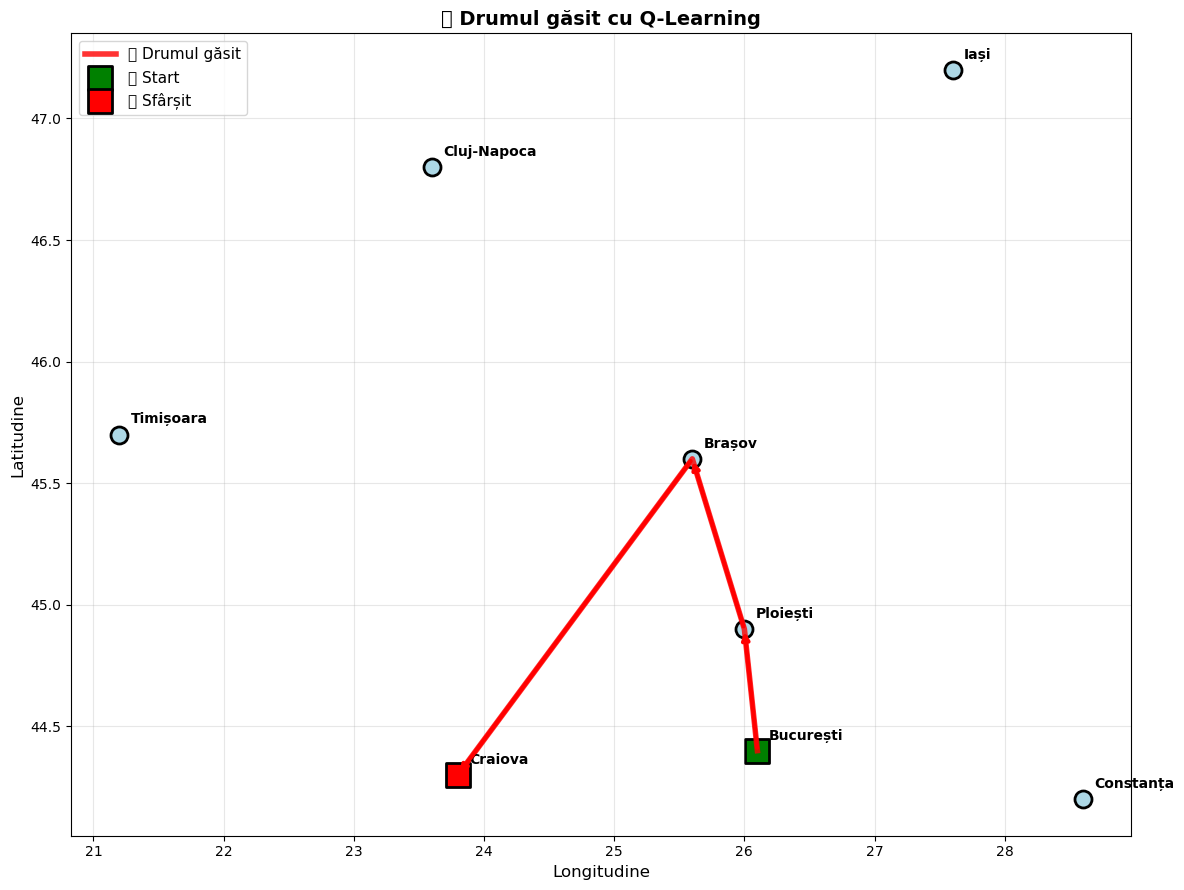

In [9]:
def afiseaza_rezultate_text(drum, distanta_totala, matricea_distante, lista_orase):
    """Afișează rezultatele în format text"""
    print(f"\n{'='*60}")
    print("🗺️  DRUMUL GĂSIT:")
    print(f"{'='*60}")
    
    for i, oras_index in enumerate(drum):
        nume_oras = lista_orase[oras_index]
        if i < len(drum) - 1:
            urmatorul_oras = lista_orase[drum[i + 1]]
            distanta_segment = matricea_distante[oras_index][drum[i + 1]]
            print(f"{i+1:2d}. {nume_oras:<12} → {urmatorul_oras:<12} ({distanta_segment:.1f} km)")
        else:
            print(f"{i+1:2d}. {nume_oras:<12} (🎯 DESTINAȚIE)")
    
    print(f"\n📏 Distanța totală: {distanta_totala:.1f} km")
    print(f"🏙️  Numărul de orașe: {len(drum)}")

def deseneaza_harta(drum, orase, lista_orase):
    """Desenează harta cu drumul găsit"""
    plt.figure(figsize=(12, 9))
    
    # Desenează toate orașele
    for nume_oras, coordonate in orase.items():
        plt.scatter(coordonate[1], coordonate[0], s=150, c='lightblue', 
                   edgecolor='black', linewidth=2)
        plt.annotate(nume_oras, (coordonate[1], coordonate[0]), 
                    xytext=(8, 8), textcoords='offset points', 
                    fontsize=10, fontweight='bold')
    
    # Desenează drumul găsit
    coordonate_drum = []
    for oras_index in drum:
        nume_oras = lista_orase[oras_index]
        coordonate = orase[nume_oras]
        coordonate_drum.append(coordonate)
    
    if len(coordonate_drum) > 1:
        coordonate_drum = np.array(coordonate_drum)
        plt.plot(coordonate_drum[:, 1], coordonate_drum[:, 0], 
                'r-', linewidth=4, label='🚗 Drumul găsit', alpha=0.8)
        
        # Adaugă săgeți pentru direcție
        for i in range(len(coordonate_drum)-1):
            start_point = coordonate_drum[i]
            end_point = coordonate_drum[i+1]
            plt.annotate('', xy=(end_point[1], end_point[0]), 
                        xytext=(start_point[1], start_point[0]),
                        arrowprops=dict(arrowstyle='->', color='red', lw=3))
        
        # Marchează startul și sfârșitul
        plt.scatter(coordonate_drum[0, 1], coordonate_drum[0, 0], 
                   s=300, c='green', marker='s', label='🟢 Start', 
                   edgecolor='black', linewidth=2)
        plt.scatter(coordonate_drum[-1, 1], coordonate_drum[-1, 0], 
                   s=300, c='red', marker='s', label='🔴 Sfârșit', 
                   edgecolor='black', linewidth=2)
    
    plt.xlabel('Longitudine', fontsize=12)
    plt.ylabel('Latitudine', fontsize=12)
    plt.title('🗺️ Drumul găsit cu Q-Learning', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Afișează rezultatele
afiseaza_rezultate_text(drumul_optim, distanta_finala, matricea_distante, lista_orase)
deseneaza_harta(drumul_optim, orase, lista_orase)

In [10]:
# Analizează tabelul Q pentru a vedea ce a învățat agentul
def analizeaza_tabel_q(tabel_q, lista_orase):
    """Analizează ce a învățat agentul"""
    print("🧠 ANALIZA CUNOȘTINȚELOR AGENTULUI:")
    print("="*50)
    
    for i, oras_start in enumerate(lista_orase):
        valori_oras = tabel_q[i]
        if np.any(valori_oras != 0):  # Doar dacă are valori diferite de 0
            print(f"\nDin {oras_start}:")
            for j, valoare in enumerate(valori_oras):
                if valoare != 0:
                    oras_destinatie = lista_orase[j]
                    print(f"  → {oras_destinatie:<12}: {valoare:8.2f}")

# Experimentează cu parametri diferiți
def experimenta_parametri():
    """Testează cum influențează parametrii rezultatele"""
    print("🔬 EXPERIMENTE CU PARAMETRI DIFERIȚI:")
    print("="*50)
    
    parametri_test = [
        {'rata': 0.05, 'discount': 0.8, 'explorare': 0.1},
        {'rata': 0.2, 'discount': 0.95, 'explorare': 0.3},
        {'rata': 0.1, 'discount': 0.9, 'explorare': 0.2}  # Original
    ]
    
    for i, params in enumerate(parametri_test):
        print(f"\n🧪 Experiment {i+1}:")
        print(f"   Rata învățare: {params['rata']}")
        print(f"   Discount: {params['discount']}")
        print(f"   Explorare: {params['explorare']}")
        
        # Aici ai putea rula din nou antrenamentul cu acești parametri
        # și compara rezultatele

analizeaza_tabel_q(tabel_q_antrenat, lista_orase)
experimenta_parametri()

🧠 ANALIZA CUNOȘTINȚELOR AGENTULUI:

Din București:
  → Craiova     :   -39.63
  → Brașov      :   -41.06
  → Ploiești    :   -39.34

Din Craiova:
  → Brașov      :   -42.78
  → Ploiești    :   -42.29

Din Brașov:
  → Cluj-Napoca :   -47.33
  → Craiova     :   -46.57
  → Ploiești    :   -44.27

Din Ploiești:
  → Craiova     :   -45.26
  → Brașov      :   -42.90
🔬 EXPERIMENTE CU PARAMETRI DIFERIȚI:

🧪 Experiment 1:
   Rata învățare: 0.05
   Discount: 0.8
   Explorare: 0.1

🧪 Experiment 2:
   Rata învățare: 0.2
   Discount: 0.95
   Explorare: 0.3

🧪 Experiment 3:
   Rata învățare: 0.1
   Discount: 0.9
   Explorare: 0.2
